<a href="https://colab.research.google.com/github/aaalexlit/omdena_climate_change_challenge_notebooks/blob/main/Index_scientific_papers_abstracts_for_searches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index scientific papers abstracts for searches

## Download csv with the abstracts retrieved from OpenAlex using keyword search

This is a short version that has only about 2000 abstracts

The csv was obtained using [this code](https://github.com/mcallaghan/NLP-climate-science-tutorial-CCAI/blob/main/A_obtaining_data.ipynb) with some minor modifications from https://openalex.org/ 

In [1]:
!gdown https://drive.google.com/uc?id=1RzgO3aWvYO4OXTD-z_LfQyuO2IE9PmbT -O 'openalex_abstracts.csv'

Downloading...
From: https://drive.google.com/uc?id=1RzgO3aWvYO4OXTD-z_LfQyuO2IE9PmbT
To: /content/openalex_abstracts.csv
100% 2.91M/2.91M [00:00<00:00, 91.1MB/s]


# Check if GPU is available to install gpu version of faiss

In [2]:
import torch
import os
faiss_to_install = "faiss-gpu"
if not torch.cuda.is_available():
  faiss_to_install = "faiss"

ret_code = os.system(f"pip install farm-haystack[{faiss_to_install}]")
if not ret_code:
  print(f"Installed {faiss_to_install}")

Installed faiss-gpu


# Index documents 

In [3]:
import os
from haystack.document_stores import FAISSDocumentStore
from haystack.nodes import EmbeddingRetriever
import logging
from timeit import default_timer as timer
from haystack import Document
import pandas as pd
import torch
from transformers import AutoTokenizer, pipeline, RobertaForSequenceClassification

## Choice of model
 

[https://www.sbert.net/docs/pretrained-models/msmarco-v3.html](https://www.sbert.net/docs/pretrained-models/msmarco-v3.html)

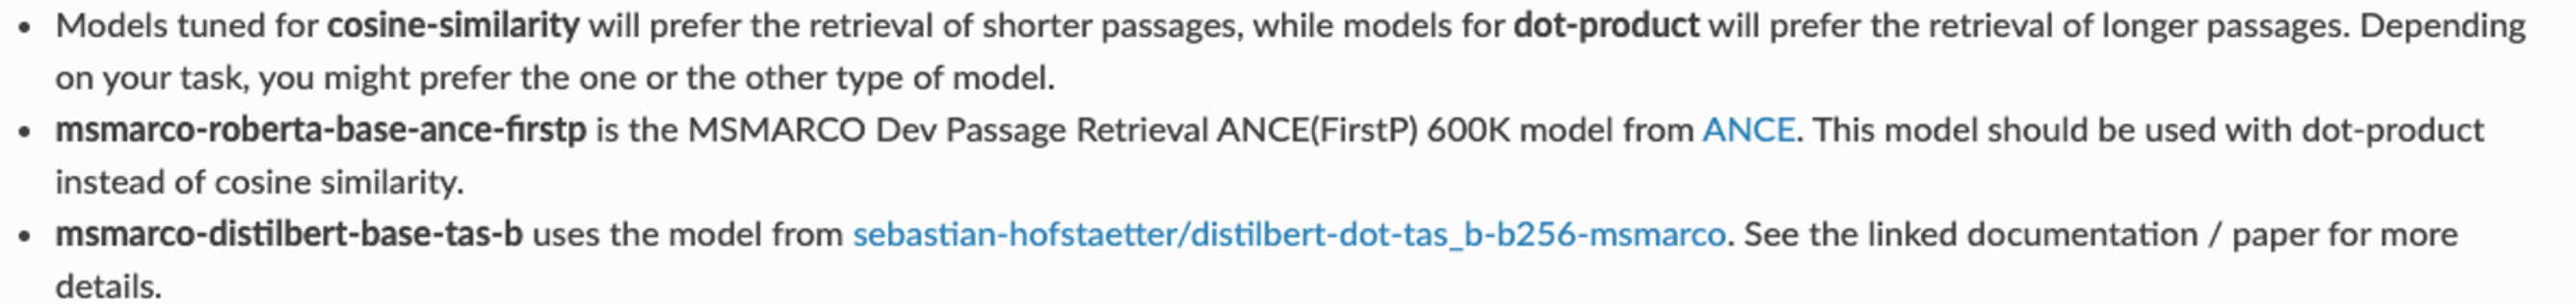

In [4]:
# model to build semantic encodings
MODEL_NAME = 'sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco'
# embedding size used by distilbert-dot-tas_b-b256-msmarco
EMBEDDING_DIM = 768

chunk_size = 128
start_from_row = 0 * chunk_size

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)


## Check if the abstract is climate-related

In [5]:
climatebert_tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-f")
climate_attention_model = RobertaForSequenceClassification.from_pretrained('kruthof/climateattention-ctw',
                                                                           num_labels=2)

In [6]:
def is_about_climate(texts):
    device = 0 if torch.cuda.is_available() else -1
    pipe = pipeline("text-classification", model=climate_attention_model,
                    tokenizer=climatebert_tokenizer, device=device,
                    truncation=True, padding=True)
    labels = []
    probs = []
    for out in pipe(texts, batch_size=64):
        labels.append(out['label'])
        probs.append(out['score'])
    return labels, probs

In [7]:
def filter_climate_related(docs):
    abstracts = list(map(lambda doc: doc.content, docs))
    labels, _ = is_about_climate(abstracts)
    return [doc for label, doc in zip(labels, docs) if label == 'Yes']

## Class that deals with initiating and writing to faiss store

In [8]:
class FAISSIndexer():
    def __init__(self, path_to_index_dir,
                 model_name, embedding_dim
                 , path_to_postgres=None) -> None:
        self.path_to_index_dir = path_to_index_dir
        # our db is postgres, only need to set path to faiss index
        if path_to_postgres:
            self.path_to_db = path_to_postgres
            self._set_path_to_index()
        # our db is SQLLite
        else:
            self._set_path_to_index_and_db()
        self.embedding_dim = embedding_dim
        self.model_name = model_name
        self.document_store = self._init_document_store()
        self.retriever = self._init_retriever()

    def _set_path_to_index(self):
        if not os.path.exists(self.path_to_index_dir):
            os.makedirs(self.path_to_index_dir)
        self.path_to_index = os.path.join(self.path_to_index_dir, "faiss_index")

    def _set_path_to_index_and_db(self):
        self._set_path_to_index()
        self.path_to_db = f"sqlite:///{os.path.join(self.path_to_index_dir, 'faiss_document_store.db')}"

    def _init_document_store(self):
        if os.path.exists(self.path_to_index):
            return FAISSDocumentStore.load(index_path=self.path_to_index)
        else:
            return FAISSDocumentStore(
                sql_url=self.path_to_db,
                return_embedding=True,
                similarity='cosine',
                embedding_dim=self.embedding_dim,
                duplicate_documents='skip'
            )

    def _init_retriever(self, progress_bar=True):
        return EmbeddingRetriever(
            document_store=self.document_store,
            embedding_model=self.model_name,
            model_format='sentence_transformers',
            # include article title into the embedding
            embed_meta_fields=["title"],
            progress_bar=progress_bar
        )

    def write_documents(self, docs):
        self.document_store.write_documents(docs)

        print('Updating embeddings ...')

        self.document_store.update_embeddings(
            retriever=self.retriever,
            update_existing_embeddings=False
        )

        print(f'current embedding count is {self.document_store.get_embedding_count()}')
        self.document_store.save(index_path=self.path_to_index)

    def retrieve_matches_for_a_phrase(self, phrase, top_k=10):
        return self.retriever.retrieve(phrase, top_k=top_k)

    def retrieve_matches_for_phrases(self, phrases, top_k=10):
        return self.retriever.retrieve_batch(phrases, top_k=top_k)

In [9]:
def index_docs_from_csv(filename, docs_extractor,
                        indexer, chunk_size, start_from_row,
                        check_climate_related=True):
    for docs in docs_extractor(filename, chunk_size, start_from_row):
        if check_climate_related:
            docs = filter_climate_related(docs)
        indexer.write_documents(docs)

In [10]:
def convert_openalex_abstracts_to_haystack_documents(row):
    meta_information = {
        'title': row['title'],
        'publication_year': row['publication_year'],
        'authors': row['authors'],
        'doi': row['doi'],
        'open_alex_id': row['id']
    }
    return Document(content=row['abstract'],
                    meta=meta_information)

In [11]:
def read_csv_yield_haystack_documents(filename, chunk_size, start_from_row):
    chunk_number = 1
    for df in pd.read_csv(filename, chunksize=chunk_size, skiprows=range(1, start_from_row)):
        print(f'starting to index chunk number {chunk_number}')
        df.fillna("", inplace=True)
        row_dict = df.to_dict('records')
        chunk_number += 1
        yield [convert_openalex_abstracts_to_haystack_documents(row)
               for row in row_dict]

In [12]:
start = timer()

STORE_PATH = '/content/data/faiss/'
csv_path = '/content/openalex_abstracts.csv'

faiss_indexer = FAISSIndexer(STORE_PATH, 
                             MODEL_NAME, 
                             EMBEDDING_DIM)
index_docs_from_csv(csv_path,
                    read_csv_yield_haystack_documents,
                    faiss_indexer,
                    chunk_size,
                    start_from_row
                    )

end = timer()
print(end - start)

starting to index chunk number 1


Writing Documents:   0%|          | 0/128 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/128 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 128
starting to index chunk number 2


Writing Documents:   0%|          | 0/126 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/254 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 254
starting to index chunk number 3


Writing Documents:   0%|          | 0/127 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/381 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 381
starting to index chunk number 4


Writing Documents:   0%|          | 0/128 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/509 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 509
starting to index chunk number 5


Writing Documents:   0%|          | 0/127 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/636 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 636
starting to index chunk number 6


Writing Documents:   0%|          | 0/127 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/763 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 763
starting to index chunk number 7


Writing Documents:   0%|          | 0/128 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/891 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 891
starting to index chunk number 8


Writing Documents:   0%|          | 0/124 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/1015 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 1015
starting to index chunk number 9


Writing Documents:   0%|          | 0/128 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/1143 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 1143
starting to index chunk number 10


Writing Documents:   0%|          | 0/128 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/1271 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 1271
starting to index chunk number 11


Writing Documents:   0%|          | 0/127 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/1398 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 1398
starting to index chunk number 12


Writing Documents:   0%|          | 0/126 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/1524 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 1524
starting to index chunk number 13


Writing Documents:   0%|          | 0/125 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/1649 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 1649
starting to index chunk number 14


Writing Documents:   0%|          | 0/126 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/1775 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 1775
starting to index chunk number 15


Writing Documents:   0%|          | 0/128 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/1903 [00:00<?, ? docs/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

current embedding count is 1903
starting to index chunk number 16


Writing Documents:   0%|          | 0/78 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/1981 [00:00<?, ? docs/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

current embedding count is 1981
99.11939393200001


In [13]:
def get_abstracts_matching_claims(claims, store_path, top_k=10, debug=False):
    start = timer()
    faiss_indexer = FAISSIndexer(store_path, MODEL_NAME, EMBEDDING_DIM)
    all_matches = faiss_indexer.retrieve_matches_for_phrases(claims,
                                                             top_k=top_k)
    if debug:
        for claim_n, matches in enumerate(all_matches):
            print(f"Claim:\n{claims[claim_n]}\n")
            for i, match in enumerate(matches):
                print(f'Evidence {i}:\n',
                      f'Similarity: {match.score:.3f}\n'
                      f'Abstract: {match.content}\n',
                      f'Article Title: {match.meta.get("title", "")}\n',
                      f'DOI: {match.meta.get("doi", "")}\n',
                      f'year: {match.meta.get("publication_year", "")}\n', )
    end = timer()
    print(f"Took {(end - start):.0f} seconds")
    return all_matches

## Find abstracts relevant to the query

Even with such a small amount of abstracts the result looks fairly reasonable

In [14]:
get_abstracts_matching_claims(['CO2 is not the cause of our current warming trend.',
                               'Natural variation explains a substantial part of global warming observed since 1850'], 
                              store_path=STORE_PATH, debug=True);

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Claim:
CO2 is not the cause of our current warming trend.

Evidence 0:
 Similarity: 0.927
Abstract: Anthropogenic climate change is predicted to be a major cause of species extinctions in the next 100 years. But what will actually these extinctions? For example, it limited physiological tolerance high temperatures, changing biotic interactions or other factors? Here, we systematically review proximate causes climate-change related and their empirical support. We find 136 case studies climatic impacts that are potentially relevant this topic. However, only seven identified demonstrated local due anthropogenic change. Among studies, vary widely. Surprisingly, none show straightforward relationship between extinction tolerances temperature. Instead, many implicate as an important cause, especially decreases food availability. very similar patterns showing abundance associated with change, those oscillations. Collectively, results highlight our disturbingly knowledge crucial issue but also